In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from graph_world.sbm.sbm_simulator import _GenerateNodeMemberships, _ComputeExpectedEdgeCounts, StochasticBlockModel
import graph_tool.all as gt

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:1501: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [2]:
def SimulateSbm(sbm_data,
                num_vertices,
                num_edges,
                pi,
                prop_mat,
                out_degs=None):
  """Generates a stochastic block model, storing data in sbm_data.graph.
  This function uses graph_tool.generate_sbm. Refer to that
  documentation for more information on the model and parameters.
  Args:
    sbm_data: StochasticBlockModel dataclass to store result data.
    num_vertices: (int) number of nodes in the graph.
    num_edges: (int) expected number of edges in the graph.
    pi: iterable of non-zero community size proportions. Must sum to 1.0.
    prop_mat: square, symmetric matrix of community edge count rates.
    out_degs: Out-degree propensity for each node. If not provided, a constant
      value will be used. Note that the values will be normalized inside each
      group, if they are not already so.
  Returns: (none)
  """
  if round(abs(np.sum(pi) - 1.0), 12) != 0:
    raise ValueError("entries of pi ( must sum to 1.0")
  if prop_mat.shape[0] != len(pi) or prop_mat.shape[1] != len(pi):
    raise ValueError("prop_mat must be k x k where k = len(pi)")
  sbm_data.graph_memberships = _GenerateNodeMemberships(num_vertices, pi)
  edge_counts = _ComputeExpectedEdgeCounts(num_edges, num_vertices, pi,
                                           prop_mat)
  sbm_data.graph = graph_tool.generation.generate_sbm(
    sbm_data.graph_memberships, edge_counts, out_degs)
  graph_tool.stats.remove_self_loops(sbm_data.graph)
  graph_tool.stats.remove_parallel_edges(sbm_data.graph)
  sbm_data.graph.reindex_edges()

In [3]:
from scipy.stats import pareto

In [4]:
def _get_pareto_exponent(degrees, offset=0.0):
  degrees = np.array(degrees)
  n = len(degrees)
  dmin = np.min(degrees)
  alpha = n / np.sum(np.log((degrees + offset) / (dmin + offset)))
  return alpha

In [5]:
num_vertices = 500
k = 2
p_to_q_ratio = 1.0
pareto_exponent = 10.0
avg_degree = 5.0


pi = np.ones(shape=(k)) / k
prop_mat = np.ones(shape=(k, k)) + np.identity(k) * (p_to_q_ratio - 1.0)
num_edges = num_vertices * avg_degree
out_degs = pareto.rvs(pareto_exponent, size=num_vertices)

(array([333., 103.,  38.,  15.,   5.,   4.,   1.,   0.,   0.,   1.]),
 array([1.0003226 , 1.11499398, 1.22966536, 1.34433674, 1.45900812,
        1.57367951, 1.68835089, 1.80302227, 1.91769365, 2.03236503,
        2.14703641]),
 <BarContainer object of 10 artists>)

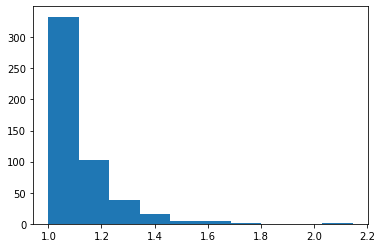

In [6]:
plt.hist(out_degs)

In [7]:
_get_pareto_exponent(out_degs)

9.75427740655056

In [8]:
_get_pareto_exponent(out_degs / np.sum(out_degs))

9.754277406550559

[ 8  1  9  5  8  5  5 13  7  8  7  0  5  3  4  4  5  1  8 10  5 10  2  2
  7  5  2  6  7  5  2  7  4  4  2  5  9  5  4  2  4  5  7  4  4  3  4  7
  2  4  4  1  3  4  8  8  6  8  3  9  2  4  5  3  9  5  3  4  6  5  4  0
  5  8  5  4  1  5  8  3  4  5  3  2  7  6  3  2  5  5  9  3  6  6  4  5
  6  7  7  8  7  4  4  4  5  7  5  4  4  6  1  4  4  2  5  3  5  5  3  3
  8  6  1  8  3  2  4  3  5  4  5  6  5  3  5  6  0  6  2  2  7  4  6  2
  3  2  4  2  3  5  3  3 10  5  5  4  6  4  5  3  4  4  8  5  3  1  6  6
  5  5  5  2  3  7  3  2  5 10  8  4  8  7  7  4  8  3  3  4  5  7  7  6
  4  4  4  9  6  6  5  3  6  9  4  5  6  4  5  7  6  4  9 10  4  6  4  2
  6  4  6  4  4  4  8  3  2  5  6  7  7  5  3  4  4  1  5  5  4  7  6  5
  3  4 11  4  8  9  3  4  4  6  4  7  7  2  6  3  4  8  9  6  5  2  3  5
  8 13  6  5  4  5  3  5  7  2  6  8  2  6  7  2  7  5  8  4  3  6  3  6
  1  8  4  5  5  6  4  6  4  5  5  3  2  5  5  4 10  3  6  3  7 10  8  4
  9  3  2  5  3  4  7  8  5  5  6  4  5  3  5  2 10

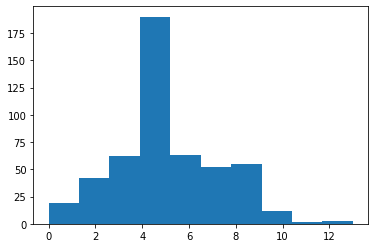

In [9]:
sbm_data = StochasticBlockModel()
sbm_data.graph_memberships = _GenerateNodeMemberships(num_vertices, pi)
edge_counts = _ComputeExpectedEdgeCounts(
    num_edges, num_vertices, pi, prop_mat)
sbm_data.graph = gt.generate_sbm(
        sbm_data.graph_memberships, edge_counts, out_degs)

degrees = sbm_data.graph.get_out_degrees(sbm_data.graph.get_vertices())
print(degrees)
plt.hist(degrees)
print(_get_pareto_exponent(degrees, 1.0))
print(np.mean(degrees))

In [10]:
from math import floor
from scipy.stats import gaussian_kde

def get_pareto_distribution(n, b, idealized=False):
    if idealized:
        quantiles = np.arange(1, n + 1) / (n + 1)
        samples = pareto.isf(quantiles, b=b)
    else:
        samples = pareto.rvs(b, size=n)
    return samples

def density_plot(data):
    density = gaussian_kde(data)
    xs = np.linspace(1,5,200)
    plt.plot(xs,density(xs))
    plt.show()
    
def convert_vector_to_expected_degrees(v, num_edges):
    v = v / np.sum(v)
    v = v * num_edges
    return v
    
def plot_pareto(n, b, idealized=False):
    x = get_pareto_distribution(n, b, idealized=idealized)
    density_plot(x)
    plt.hist(x)
    plt.show()
    print(_get_pareto_exponent(x))

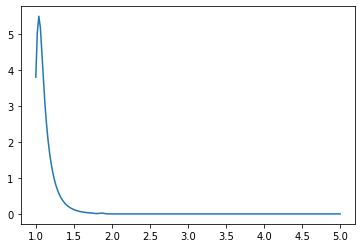

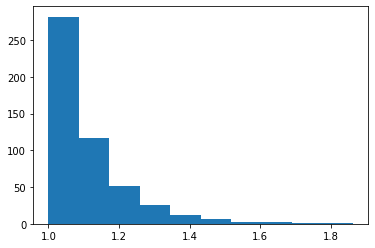

10.081181928315246


In [11]:
plot_pareto(500, 10.0, idealized=True)

In [27]:
def convert_edgelist_to_graph(edgelist, N):
    gt_graph = gt.Graph(directed=False)
    _ = gt_graph.add_vertex(N)
    gt_graph.add_edge_list(edgelist)
    return gt_graph

def generate_degree_graph_slow(degrees, random_seed=12345):

    np.random.seed(random_seed)
    degrees = sorted(degrees, reverse=True)
    E = []
    S = np.sum(degrees) * 2.0
    N = len(degrees)
    
    for u in range(N - 1):
        for v in range(u, N):
            r = np.random.uniform()
            if r < min(degrees[u] * degrees[v] / S, 1.0):
                E.append((u, v))
                E.append((v, u))
                
    gt_graph = convert_edgelist_to_graph(E, N)
    return gt_graph
        

def generate_degree_graph(degrees, random_seed=12345):

    np.random.seed(random_seed)
    degrees = sorted(degrees, reverse=True)
    E = []
    S = np.sum(degrees) * 2.0
    N = len(degrees)
    for u in range(0, N - 1):
        v = u + 1
        p = min(degrees[u] * degrees[v] / S, 1.0)
        while v < N and p > 0:
            if p != 1.0:
                r = np.random.uniform()
                v = v + floor(np.log(r) / np.log(1 - p))
            if v < N:
                q = min(degrees[u] * degrees[v] / S, 1.0)
                r = np.random.uniform()
                if r < q / p:
                    E.append((u, v))
                    E.append((v, u))
                p = q
                v = v + 1

    gt_graph = convert_edgelist_to_graph(E, N)
    return gt_graph

def generate_degree_graph_gt(degrees):
    
    num_vertices = len(degrees)
    k = 2
    p_to_q_ratio = 1.0
    pi = np.ones(shape=(k)) / k
    prop_mat = np.ones(shape=(k, k)) + np.identity(k) * (p_to_q_ratio - 1.0)
    num_edges = np.sum(degrees)
    
    sbm_data = StochasticBlockModel()
    sbm_data.graph_memberships = _GenerateNodeMemberships(num_vertices, pi)
    edge_counts = _ComputeExpectedEdgeCounts(
        num_edges, num_vertices, pi, prop_mat)
    sbm_data.graph = gt.generate_sbm(
            sbm_data.graph_memberships, edge_counts, out_degs)
    
    return sbm_data.graph

def sample_graph_degrees_gt(degrees):
    
    gt_graph = generate_degree_graph_gt(degrees)
    sampled_degrees = gt_graph.get_out_degrees(gt_graph.get_vertices())
    return sampled_degrees
    
def gini(array):
    array = array.astype(np.float32)
    array += np.finfo(np.float32).eps
    array = np.sort(array)
    n = array.shape[0]
    index = np.arange(1, n + 1)
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [44]:
paretos = np.linspace(1.0, 10.0, 50)
num_samples = 10
num_vertices = 500

gini_avgs = np.zeros(shape=(len(paretos)))
gini_true = np.zeros(shape=(len(paretos)))

for i, b in enumerate(paretos):
    gini_values = []
    true_degrees = get_pareto_distribution(num_vertices, b, idealized=True)
    true_degrees = convert_vector_to_expected_degrees(true_degrees, 5000.0)
    gini_true[i] = gini(true_degrees)
    
    for _ in range(num_samples):
        
        degrees = sample_graph_degrees_gt(true_degrees)
        gini_values.append(gini(degrees))
    
    gini_avgs[i] = np.mean(gini_values)

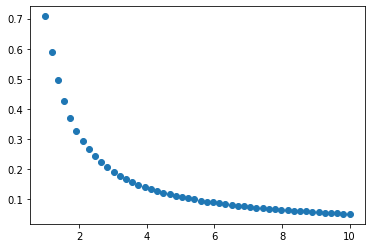

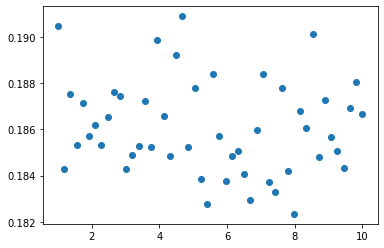

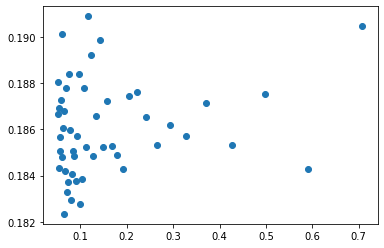

In [45]:
plt.scatter(paretos, gini_true)
plt.show()
plt.scatter(paretos, gini_avgs)
plt.show()
plt.scatter(gini_true, gini_avgs)
plt.show()

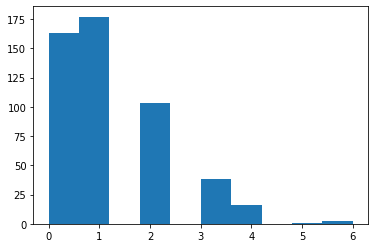

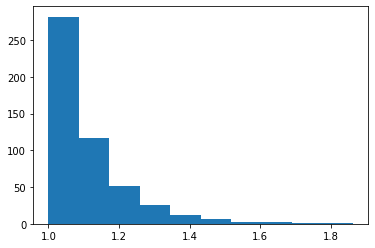

In [43]:
plt.hist(degrees)
plt.show()
plt.hist(true_degrees)
plt.show()

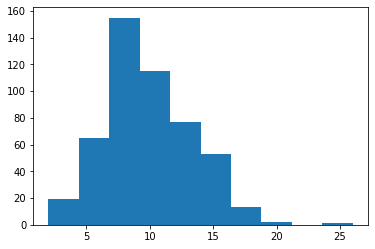

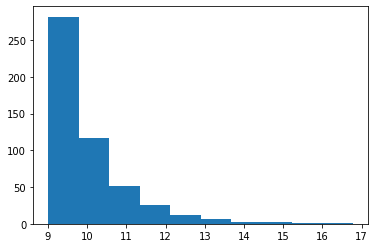

In [46]:
plt.hist(degrees)
plt.show()
plt.hist(true_degrees)
plt.show()

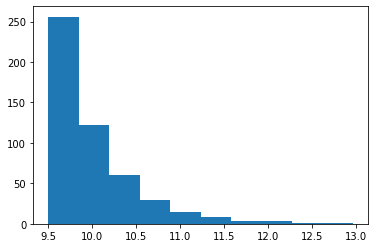

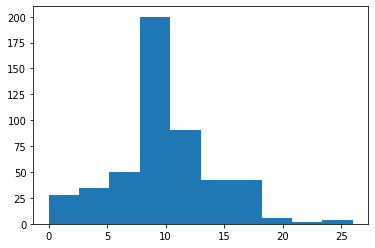

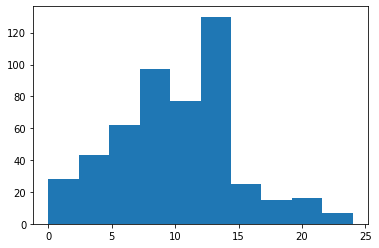

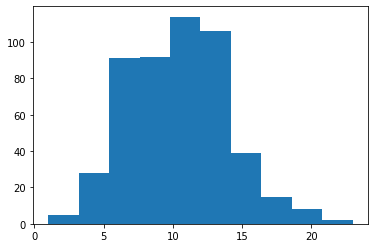

In [19]:
n = 500
avg_degree = 10.0
b = 20.0

true_degrees = convert_vector_to_expected_degrees(
    get_pareto_distribution(n, b, idealized=True), n * avg_degree)
plt.hist(true_degrees)
plt.show()

gt_graph = generate_degree_graph(true_degrees)
degrees = gt_graph.get_out_degrees(gt_graph.get_vertices())
plt.hist(degrees)
plt.show()

gt_graph_slow = generate_degree_graph_slow(true_degrees)
degrees_slow = gt_graph_slow.get_out_degrees(gt_graph_slow.get_vertices())
plt.hist(degrees_slow)
plt.show()

gt_graph_gt = generate_degree_graph_gt(true_degrees)
degrees_gt = gt_graph_gt.get_out_degrees(gt_graph_gt.get_vertices())
plt.hist(degrees_gt)
plt.show()

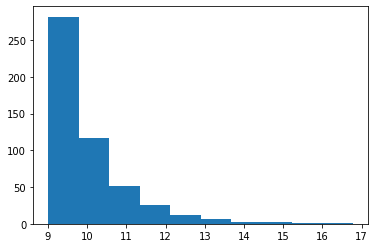

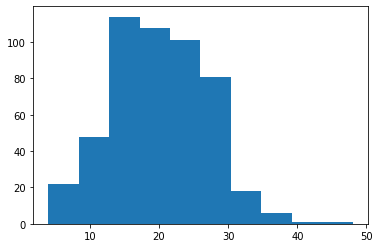

In [169]:
n = 500
avg_degree = 10.0
b = 10.0

weights = convert_vector_to_expected_degrees(
    get_pareto_distribution(n, b, idealized=True), n * avg_degree)
gt_graph = generate_degree_graph_slow(weights)
degrees = gt_graph.get_out_degrees(gt_graph.get_vertices())
plt.hist(weights)
plt.show()
plt.hist(degrees)
plt.show()

In [174]:
gt_graph.get_vertices()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [153]:
len(E)

5196

In [139]:
np.random.uniform()

0.31818949537898944

In [138]:
np.sum(weights)

5000.0

In [3]:
nsamples = 4
graph_samples = [GenerateStochasticBlockModelWithFeatures(
            num_vertices = 50,
            num_edges = 400,
            pi = np.array([0.25, 0.25, 0.25, 0.25]),
            prop_mat = np.ones((4, 4)) + 25.0 * np.diag([1,1,1,1]),
            feature_center_distance = 2.0,
            feature_dim = 16,
            edge_center_distance = 2.0,
            edge_feature_dim = 4) for i in range(nsamples)]

# colors = {0: [0, 0, 1, 1],
#           1: [0, 1, 0, 1],
#           2: [1, 0, 0, 1],
#           3: [1, 1, 0, 1]}
cmap = plt.cm.tab10
cmaplist = [cmap(i) for i in range(cmap.N)]
print(cmaplist)

pmaps = []
for graph_wrapper in graph_samples:
    memberships = graph_wrapper.graph_memberships
    pmap = graph_wrapper.graph.new_vertex_property("vector<double>")
    for v in graph_wrapper.graph.vertices():
        member = memberships[int(v)]
        pmap[v] = cmaplist[member]
        
    pmaps.append(pmap)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]


In [4]:
import os
outdir="/tmp/sbm/notebook"
if not os.path.isdir(outdir):
    os.makedirs(outdir)
for i, graph in enumerate(graph_samples):
    gt.graph_draw(graph.graph, vertex_fill_color=pmaps[i], output=outdir + "/graph_{0:03d}.png".format(i))

In [55]:
num_vertices = 500
p_to_q_ratio = 3.0
pi = np.array([3.0, 1.0])
pi = np.array([1.0, 1.0])
num_edges = 5000

pi = pi / np.sum(pi)
degrees = np.ones(shape=(num_vertices))
degrees = num_edges * degrees / np.sum(degrees)

k = len(pi)
prop_mat = [[2.0, 1.0], [1.0, 2.0]]
num_vertices = len(degrees)
prop_mat = np.ones(shape=(k, k)) + np.identity(k) * (p_to_q_ratio - 1.0)
num_edges = np.sum(degrees)

memberships = _GenerateNodeMemberships(num_vertices, pi)
edge_counts = _ComputeExpectedEdgeCounts(
    num_edges, num_vertices, pi, prop_mat)


In [56]:
edge_counts

array([[1875.,  625.],
       [ 625., 1875.]])

In [52]:
num_edges

500.0